In [17]:
from math import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy import stats
import re
from scipy.stats import boxcox, ttest_ind
from scipy.special import inv_boxcox
import sklearn as sk
from sklearn.preprocessing import power_transform
from sklearn.cluster import KMeans
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap as Basemap
import mplleaflet

#network analysis packages
import networkx as nx
import community
from community import community_louvain
import warnings
from matplotlib.collections import LineCollection

#optimization packages
import gurobipy as grb

from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import difflib #for finding closest word match
import os

# 0. Preprocessing

In [18]:
#read in data files with processed data 
CA_flight_network_scaled = pd.read_csv('Save Points/6/CA_flight_network_scaled_loc.csv')
distance_ratios = pd.read_csv('Save Points/2/frac_in_CA.csv').rename(columns = {'Unnamed: 0': 'OD Pair Name'}).set_index('OD Pair Name').to_dict()['Frac in CA']
CA_flight_network_scaled['UID Route'] = [a + b for a,b in list(zip(CA_flight_network_scaled['Departure'], CA_flight_network_scaled['Arrival']))]
CA_flight_network_scaled = CA_flight_network_scaled.drop('Unnamed: 0', axis = 1)



In [19]:
CA_flight_network_scaled

,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),...,Distance (mi),True Dist (mi),Dep Lat,Dep Lon,Arr Lat,Arr Lon,Route Type,Common A/C Type,CO2 Community,UID Route
0,ACVSFO,ACV,SFO,2290,41.261572,20.302620,0.168058,0.529677,0.000074,0.000967,...,249.657803,249.657803,40.978101,-124.109000,37.618999,-122.375000,Intra-CA,CL600RJ,1212.960993,ACVSFO
1,ACVSFO,SFO,ACV,2294,39.168875,29.882738,0.165229,0.520813,0.000091,0.001156,...,249.657803,249.657803,37.618999,-122.375000,40.978101,-124.109000,Intra-CA,CL600RJ,1194.746011,SFOACV
2,APCBUR,APC,BUR,13,45.023077,16.423077,0.597740,1.883731,0.000220,0.004093,...,352.861461,352.861461,38.213200,-122.280998,34.200699,-118.359001,Intra-CA,C680,24.488509,APCBUR
3,APCBUR,BUR,APC,20,49.200000,18.500000,0.657299,2.071422,0.000221,0.004672,...,352.861461,352.861461,34.200699,-118.359001,38.213200,-122.280998,Intra-CA,C680,41.428442,BURAPC
4,APCLAS,LAS,APC,22,60.281818,21.181818,0.614601,1.936452,0.000655,0.003545,...,338.002481,419.989531,36.080101,-115.152000,38.213200,-122.280998,Domestic Out-of-CA,C750,42.601952,LASAPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,TRMVNY,VNY,TRM,71,21.254930,17.697183,0.837855,2.642585,0.001492,0.008656,...,139.779818,139.779818,34.209801,-118.489998,33.626701,-116.160004,Intra-CA,G400,187.623532,VNYTRM
425,TUSVNY,TUS,VNY,27,64.951852,16.981481,0.528342,1.665087,0.001425,0.003968,...,232.466165,460.589381,32.116100,-110.941002,34.209801,-118.489998,Domestic Out-of-CA,C750,44.957349,TUSVNY
426,TUSVNY,VNY,TUS,29,54.996552,17.224138,0.580428,1.830041,0.001482,0.005317,...,232.466165,460.589381,34.209801,-118.489998,32.116100,-110.941002,Domestic Out-of-CA,C750,53.071191,VNYTUS
427,UDDVNY,UDD,VNY,15,26.700000,17.300000,1.019840,3.214243,0.000548,0.009193,...,131.095990,131.095990,33.748402,-116.275002,34.209801,-118.489998,Intra-CA,C680,48.213650,UDDVNY


In [20]:
#re-calculate route distances to get true distaces for out-of-CA flights
frac_in_CA = CA_flight_network_scaled['OD Pair Name'].map(distance_ratios)
frac_in_CA[frac_in_CA.isnull()] = 1
true_dist = CA_flight_network_scaled['Distance (mi)'] / frac_in_CA
CA_flight_network_scaled['True Dist (mi)'] = true_dist

In [21]:
#feasibility conditions: distance must be in-range for the two electric aircraft, and must have a 
#minimum of 12 flights in 2019 (~1 per month)

#CA_flight_network_scaled_fltr = CA_flight_network_scaled
CA_flight_network_scaled_fltr = CA_flight_network_scaled[CA_flight_network_scaled['True Dist (mi)'] < 500]
CA_flight_network_scaled_fltr = CA_flight_network_scaled_fltr[CA_flight_network_scaled_fltr['Num. of Flights'] >= 12]

#cruise speed of each common AC for each route, in knots (NM/h)
a_dict = {'CL600RJ': 424, 'E175': 430, 'G400': 473.5, 'CL700RJ': 447, 'A306': 450, 'B737': 453, 'B738': 453,
          'G500': 502, 'G650': 502, 'C208': 186, 'A319': 447.4, 'CL600': 461, 'B744': 504, 'E170': 470, 
          'BE400': 447, 'C550': 403, 'CL900RJ': 447, 'A321': 450, 'A320': 447, 'B772': 482, 'B735': 430,
          'E145': 450, 'DHC8': 360, 'BD700': 487, 'C501': 357, 'B752': 461, 'C680': 460, 'C750': 528, 
          'B763': 460}

CA_flight_network_scaled_fltr['Speed Ratio'] = CA_flight_network_scaled_fltr['Common A/C Type'].map(a_dict) / 220

In [22]:
#define ceiling function that returns integers:
def int_ceil(a, b):
    return (a - 1) // b + 1

In [23]:
N_p_ea = 9
N_p_za = 15

num_flights = CA_flight_network_scaled_fltr['Num. of Flights']
CA_flight_network_scaled_fltr['Freq. Alice Equivalent'] = int_ceil(np.round(CA_flight_network_scaled_fltr['Pax']), N_p_ea) * num_flights 
CA_flight_network_scaled_fltr['Freq. ZA Equivalent'] = int_ceil(np.round(CA_flight_network_scaled_fltr['Pax']), N_p_za) * num_flights 

In [24]:
# calculating number of aircraft needed for Eviation Alice (leaving frequency per route as an integer decision 
# variable)
time_factor = CA_flight_network_scaled_fltr['Speed Ratio']
lto_time = ((CA_flight_network_scaled_fltr['Total Taxi/Idle (min)'] - 0.5) + 4 + 2.2 + 0.7) / 60
ccd_time_adj = (time_factor * CA_flight_network_scaled_fltr['Cruise Time (min)']) / 60
CA_flight_network_scaled_fltr['Flight Hr. Coef'] = (lto_time + ccd_time_adj) / 3000
CA_flight_network_scaled_fltr['Num. Jet AC'] = np.array((CA_flight_network_scaled_fltr['Cruise Time (min)'] + lto_time) / 60 / 3000 * CA_flight_network_scaled_fltr['Freq. Alice Equivalent'])


In [25]:
num_alices = CA_flight_network_scaled_fltr['Flight Hr. Coef'] * CA_flight_network_scaled_fltr['Freq. Alice Equivalent']
num_alices = num_alices.to_dict()


In [26]:
CA_flight_network_scaled_fltr = CA_flight_network_scaled_fltr.set_index('UID Route')

In [27]:
airport_emissions_df = pd.read_csv('airport_emissions_factors.csv').drop(['Unnamed: 0', 'Action', 'Generation Mix', 'Identification of Utility Source'], axis = 1)
airport_emissions_df = airport_emissions_df.rename(columns = {"Dep. Airports": "Departure"})

#getting Eviation Alice emission factors
ef_ea_airport_mapping = airport_emissions_df[['Departure', 'Emissions Factor']].set_index('Departure').to_dict()['Emissions Factor']
CA_flight_network_scaled_fltr['EA EF (kg CO2 eq)'] = CA_flight_network_scaled_fltr['Departure'].map(ef_ea_airport_mapping)
CA_flight_network_scaled_fltr['EA EF (kg CO2 eq)'] = CA_flight_network_scaled_fltr['EA EF (kg CO2 eq)'] / 1000

#getting ZeroAvia emission factors
ef_za_airport_mapping = airport_emissions_df[['Departure', 'Emissions Factor ZeroAvia']].set_index('Departure').to_dict()['Emissions Factor ZeroAvia']
# CA_flight_network_scaled_fltr['ZA EF (kg CO2 eq)'] = CA_flight_network_scaled_fltr['Departure'].map(ef_za_airport_mapping)
# CA_flight_network_scaled_fltr['ZA EF (kg CO2 eq)'] = CA_flight_network_scaled_fltr['ZA EF (kg CO2 eq)'] / 1000
za_ef = 0.14 * 12.13 + 0.86 * 2.67
CA_flight_network_scaled_fltr['ZA EF (kg CO2 eq)'] = za_ef

battery_emissions = (61 * (820/506)) / CA_flight_network_scaled_fltr['Pax']

In [28]:
be_mean = np.mean(battery_emissions)
be_std = np.std(battery_emissions)
be_std

4.243268943370378

In [29]:
orig_total_emissions = CA_flight_network_scaled_fltr['CO2 (kg/pax/mi)']
orig_total_emissions = orig_total_emissions.to_dict()



In [30]:
CA_flight_network_scaled_fltr['Fuel Consumption (kg/pax/mi)'].min()

0.07532380674203137

# 1. Comparison Table (Eviation Alice vs. ZeroAvia ZA-600)

In [31]:
df = CA_flight_network_scaled_fltr
ea_emissions = ((1/(9 * 0.8)) * 1.62 * df['EA EF (kg CO2 eq)'] * (df['Freq. Alice Equivalent'] / df['Num. of Flights'])) + battery_emissions
za_emissions = 0.359 * df['Fuel Consumption (kg/pax/mi)'] * df['ZA EF (kg CO2 eq)'] * (df['Freq. ZA Equivalent'] / df['Num. of Flights'])
orig_emissions = df['CO2 (kg/pax/mi)'] + np.mean(CA_flight_network_scaled_fltr['Fuel Consumption (kg/pax/mi)'] * 3.68)

comparison_table = pd.DataFrame(data = {'Jet Fuel': orig_emissions, 
                                        'Electric Battery': ea_emissions, 
                                        'Hydrogen Fuel': za_emissions})

In [32]:
(5.01 / (5.01 + 0.29))

0.9452830188679245

In [33]:
jf_mean = np.mean(CA_flight_network_scaled_fltr['CO2 (kg/pax/mi)'])
print('Jet Fuel mean:', jf_mean)
eb_mean = np.mean(((1/(9 * 0.8)) * 1.62 * df['EA EF (kg CO2 eq)'] * (df['Freq. Alice Equivalent'] / df['Num. of Flights'])))
print('Electric aircraft mean:', eb_mean)
hf_mean = np.mean(za_emissions)
print('Hydrogen fuel cell mean:', hf_mean)

print('Jet Fuel median:', np.median(comparison_table['Jet Fuel']))
print('Electric aircraft median:', np.median(comparison_table['Electric Battery']))
print('Hydrogen fuel cell median:', np.median(comparison_table['Hydrogen Fuel']))

jf_std = np.std(CA_flight_network_scaled_fltr['CO2 (kg/pax/mi)'])
print('Jet Fuel std:', jf_std)
eb_std = np.std(((1/(9 * 0.8)) * 1.62 * df['EA EF (kg CO2 eq)'] * (df['Freq. Alice Equivalent'] / df['Num. of Flights'])))
print('Electric aircraft std:', eb_std)
hf_std = np.std(za_emissions)
print('Hydrogen fuel cell std:', hf_std)

jf_gg = np.mean(CA_flight_network_scaled_fltr['Fuel Consumption (kg/pax/mi)'] * 3.68)

Jet Fuel mean: 2.1993449752068894
Electric aircraft mean: 0.29101704545454593
Hydrogen fuel cell mean: 1.8788040849374594
Jet Fuel median: 3.7352664585419317
Electric aircraft median: 2.815952026150542
Hydrogen fuel cell median: 1.2995604639495142
Jet Fuel std: 3.3336682115837286
Electric aircraft std: 0.38916115853464994
Hydrogen fuel cell std: 2.1226969815469943


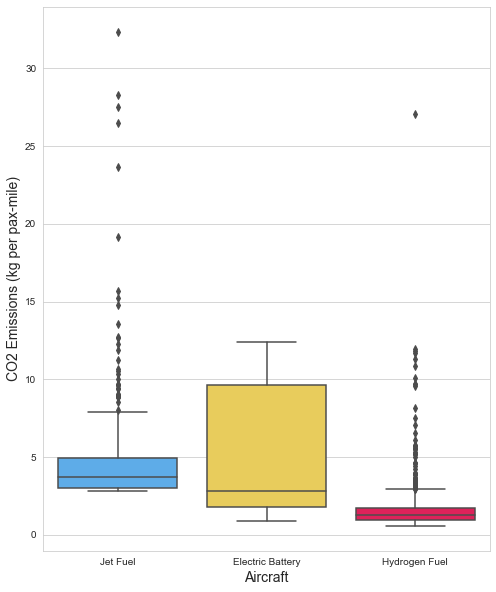

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize = (8, 10))
set_color = {'Jet Fuel': '#47afff', 'Electric Battery': '#ffda45', 'Hydrogen Fuel': '#fc034e'}
ax = sns.boxplot(x = 'variable', y = "value", data = pd.melt(comparison_table),
                     palette = set_color)

#ax.set_yscale('log')
ax.set_xlabel('Aircraft', fontsize = 14);
ax.set_ylabel('CO2 Emissions (kg per pax-mile)', fontsize = 14);
#plt.savefig('Article Figures/Final/aricraft_comparison.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()


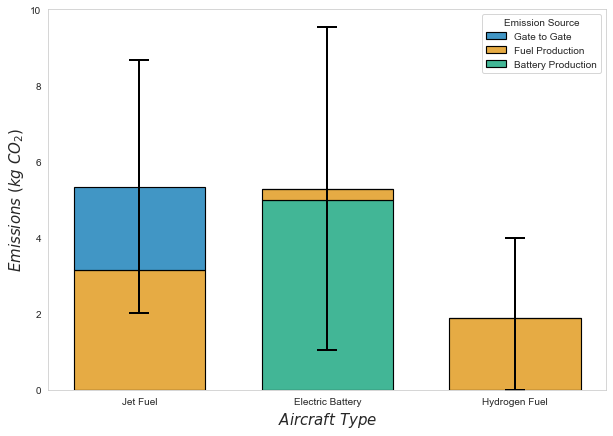

In [35]:
#barplot:
aircraft = ['Jet Fuel', 'Electric Battery', 'Hydrogen Fuel']
consumable = ['Gate to Gate'] * 3 + ['Fuel Production'] * 3 + ['Battery Production'] * 3
set_color = {'Gate to Gate': '#fc034e', 'Fuel Production': '#ffda45', 'Battery Production': '#47afff'}

# Put data in long format in a dataframe.
barplot_df = pd.DataFrame({
    'Aircraft': aircraft * 3,
    'Emission Source': consumable,
    'Emissions (kg CO2)': [jf_mean, 0, 0, 3.15, eb_mean, hf_mean, 0, be_mean, 0]})
plt.figure(figsize = (10, 7))
ax = sns.histplot(barplot_df, x = 'Aircraft', hue = 'Emission Source', weights = 'Emissions (kg CO2)', multiple='stack', 
                  palette = 'colorblind', shrink = 0.7, edgecolor = "black", linewidth = 1.15)
ax.set_ylabel('$Emissions~(kg~CO_{2})$', fontsize = 15);
ax.set_xlabel('$Aircraft~Type$', fontsize = 15);
plt.errorbar(0, jf_mean + 3.15, yerr = jf_std, capsize = 10, color = 'black', linewidth = 2, capthick = 2);
plt.errorbar(1, eb_mean + be_mean, yerr = be_std, capsize = 10, color = 'black', 
             linewidth = 2, capthick = 2)
plt.errorbar(2, hf_mean, yerr = np.array([[hf_mean], [hf_std]]), capsize = 10, color = 'black', linewidth = 2, capthick = 2)
ax.grid(False)
#plt.savefig('Article Figures/Final/aricraft_comparison_2.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [36]:
freq_ratio_dict = dict(CA_flight_network_scaled_fltr['Freq. Alice Equivalent'] / CA_flight_network_scaled_fltr['Num. of Flights'])



# 2. Optimizing Route Selection

In [37]:
CA_flight_network_scaled_fltr['EA Emissions'] = ea_emissions
CA_flight_network_scaled_fltr['ZA Emissions'] = za_emissions

In [38]:
private_jet_routes = CA_flight_network_scaled_fltr[CA_flight_network_scaled_fltr['Pax'] < 20]

In [39]:
CA_flight_network_scaled_fltr[CA_flight_network_scaled_fltr['EA Emissions'] < CA_flight_network_scaled_fltr['CO2 (kg/pax/mi)']]



,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),...,CO2 Community,Speed Ratio,Freq. Alice Equivalent,Freq. ZA Equivalent,Flight Hr. Coef,Num. Jet AC,EA EF (kg CO2 eq),ZA EF (kg CO2 eq),EA Emissions,ZA Emissions
UID Route,,,,,,,,,,,,,,,,,,,,,
BURLAX,BURLAX,BUR,LAX,88,4.395455,24.931818,1.241241,3.918651,0.002736,0.014633,...,344.841277,2.090909,440.0,264.0,0.000225,0.012021,0.4268,3.9944,2.753838,5.339778
LAXBUR,BURLAX,LAX,BUR,154,3.957143,21.045455,1.069513,3.376304,0.001942,0.010526,...,519.950870,2.090909,924.0,616.0,0.000198,0.022661,0.3211,3.9944,2.280277,6.134684
BURVNY,BURVNY,BUR,VNY,83,2.051807,17.957831,6.684484,21.112673,0.007864,0.076929,...,1752.351867,2.090909,166.0,83.0,0.000159,0.002267,0.4268,3.9944,9.890478,9.585480
VNYBUR,BURVNY,VNY,BUR,68,5.055882,16.735294,8.153299,25.735064,0.008754,0.090495,...,1749.984322,2.090909,136.0,68.0,0.000187,0.004111,0.3211,3.9944,9.957714,11.691747
OAKCCR,CCROAK,OAK,CCR,14,6.100000,18.214286,5.256908,16.606558,0.051300,0.126654,...,232.491805,2.095455,14.0,14.0,0.000208,0.000506,0.0436,3.9944,11.738222,7.538352
CNOSNA,CNOSNA,CNO,SNA,13,1.946154,19.038462,7.905388,24.979903,0.101283,0.236443,...,324.738745,2.031818,13.0,13.0,0.000163,0.000171,0.1298,3.9944,12.385924,11.336244
SNACNO,CNOSNA,SNA,CNO,15,5.700000,17.433333,7.572289,23.924979,0.091219,0.208129,...,358.874687,2.031818,15.0,15.0,0.000197,0.000508,0.1298,3.9944,12.283803,10.858583
LAXLGB,LAXLGB,LAX,LGB,120,8.700000,19.666667,2.752245,8.683885,0.004231,0.020554,...,1042.066182,2.045455,600.0,360.0,0.000244,0.030448,0.3211,3.9944,2.641601,11.840073
LGBLAX,LAXLGB,LGB,LAX,63,6.639683,19.928571,1.900226,5.997162,0.002009,0.014778,...,377.821203,2.045455,252.0,189.0,0.000222,0.009910,0.1298,3.9944,2.846509,8.174715


In [40]:
import gurobipy as grb

def optimize_routes(num_aircraft, ac_range, N_p):
    opt_model = grb.Model(name = 'Route Selection Opt')
    opt_model.Params.LogToConsole = 0
    
    MIP_df = CA_flight_network_scaled_fltr[['CO2 (kg/pax/mi)', 'Num. of Flights', 'Pax', 'EA EF (kg CO2 eq)', 'Flight Hr. Coef']]
    
    #battery fuel consumption (FC) = battery capacity (820) / range of aircraft
    eta =  820 / ac_range
    
    #frequency ratio: ratio of electric battery to jet fuel aircraft
    freq_ratio = int_ceil(np.round(MIP_df['Pax']), N_p)
    MIP_df['be_emissions'] = freq_ratio * eta * (1 / (N_p * 0.8)) * MIP_df['EA EF (kg CO2 eq)']
    MIP_df['be_count'] = freq_ratio * MIP_df['Num. of Flights'] * MIP_df['Flight Hr. Coef']

    #define constraint/objective equation coefficients
    be = {route: MIP_df.loc[route]['be_emissions'] for route in MIP_df.index} #dict of Alice emissions
    jf = {route: MIP_df.loc[route]['CO2 (kg/pax/mi)'] for route in MIP_df.index} #dict of original emissions
    be_count = {route: MIP_df.loc[route]['be_count'] for route in MIP_df.index} #dict of number of Alices for each route
    
    #add binary decision variables {0, 1}
    X_vars = {route: opt_model.addVar(vtype = grb.GRB.BINARY,
                                      name = 'x_{0}'.format(route)) for route in MIP_df.index}
    
    #constraint 1: number of electric aircraft for entire network cannot be greater than 32
    constraint_1 = opt_model.addConstr(lhs = grb.quicksum(be_count[route] * X_vars[route] for route in MIP_df.index),
                                       sense = grb.GRB.EQUAL,
                                       rhs = num_aircraft, #maximum electric aircraft to use for replacement
                                       name = "constraint1")
    
    #CO2 emissions from electric aircraft charging/electrolysis cannot be greater than jet fuel emissions constraint
    constraint_2 = {route: opt_model.addConstr(lhs = be[route] * X_vars[route], 
                                               sense = grb.GRB.LESS_EQUAL, 
                                               rhs = jf[route], 
                                               name = "constraint_{0}".format(route)) for route in MIP_df.index}
   
    #objective function: minimize total CO2 emissions across entire network
    objective_emissions = grb.quicksum((1/jf[route]) * (be[route] * X_vars[route] + jf[route] * (1 - X_vars[route])) for route in MIP_df.index)
    
    opt_model.ModelSense = grb.GRB.MINIMIZE;
    opt_model.optimize();
    obj = opt_model.getObjective();
    
    opt_df = pd.DataFrame.from_dict(X_vars, orient = "index", columns = ["variable_object"]);
    opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X);
    
    return opt_df[opt_df['solution_value'] != 0].index, be

In [41]:
optimal, be_emissions = optimize_routes(35, 506, 125)

Academic license - for non-commercial use only - expires 2022-03-15
Using license file /Users/candaceyee/gurobi.lic


In [42]:
per_route = []
reduction_per_kg = []
total_reduction = []
num_routes = []
CO2_avoided = []
prices = []
private_jets = []
original_emissions = sum(CA_flight_network_scaled_fltr['CO2 (kg/pax/mi)'] * CA_flight_network_scaled_fltr['Distance (mi)'] * CA_flight_network_scaled_fltr['Pax'] * CA_flight_network_scaled_fltr['Num. of Flights'])

print(datetime.now())
for num_aircraft in range(1, 101):
    print(num_aircraft)
    indices, a = optimize_routes(num_aircraft, 506, 9)
    in_routes = CA_flight_network_scaled_fltr.loc[indices]
    number_routes = len(in_routes)
    
    total_CO2_avoided = sum(in_routes['CO2 (kg/pax/mi)'] * in_routes['Pax'] * in_routes['Distance (mi)'] * in_routes['Num. of Flights'])
    mapped_a = in_routes.index.map(a)    
    ea_emissions_tot = sum(mapped_a * in_routes['Pax'] * in_routes['Distance (mi)'] * in_routes['Num. of Flights'])
    
    per_route_reduction = 1 - (ea_emissions_tot / total_CO2_avoided)
    total_emission_reductions = (total_CO2_avoided - ea_emissions_tot)
    percent_reduction = 1 - ((original_emissions - total_CO2_avoided + ea_emissions_tot) / original_emissions)
    price = 4e6 * num_aircraft
    reduction_USD_per_kg = (price / total_emission_reductions)
    percent_jet = sum((in_routes['Pax'] < 20) * 1) / number_routes
    
    per_route.append(per_route_reduction)
    reduction_per_kg.append(reduction_USD_per_kg)
    total_reduction.append(percent_reduction)
    num_routes.append(number_routes)
    CO2_avoided.append(total_CO2_avoided)
    prices.append(price)
    private_jets.append(percent_jet)
    
print(datetime.now())

2022-02-21 01:16:15.621594
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2022-02-21 01:17:19.203078


In [44]:
np.array(private_jets).mean()

0.6764468617448448

In [52]:
x = list(range(1, 101))
y = total_reduction
slope_1, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2
#print(r_squared, intercept, slope)

def linear(x_value, slope, intercept):
    return x_value * slope + intercept

yy = linear(range(1, 101), slope, intercept)

In [35]:
r_squared

0.5625564064840219

In [40]:
slope

0.00013458784644807242

In [42]:
num_needed = 50 / (slope * 100)
num_needed / 857

4.33494247184543

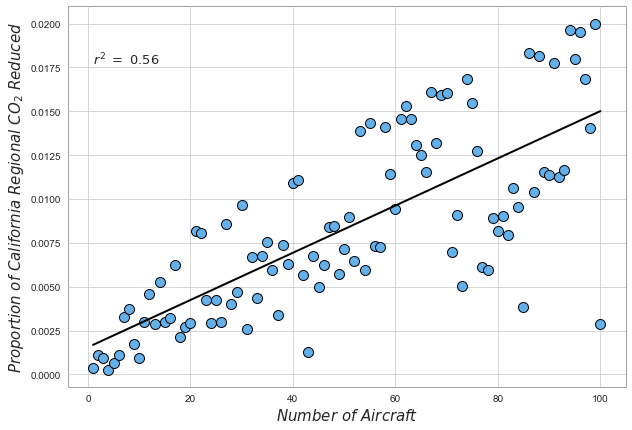

In [43]:
fig, ax = plt.subplots(figsize = (10, 7))
plt.scatter(range(1, 101), total_reduction, color = '#63b0eb', edgecolor = 'black', s = 100)
plt.plot(range(1, 101), yy, color = 'black', linewidth = 2)
plt.xlabel('$Number~of~Aircraft$', fontsize = 15)
plt.ylabel('$Proportion~of~California~Regional~CO_{2}~Reduced$', fontsize = 15)
plt.text(1, 0.0177, '$r^{2}~=~0.56$', fontsize = 13)
# plt.title('Number of Routes Replaced', fontsize = 15)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
#plt.savefig('Article Figures/Final/CO2_reduction.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [83]:
total_reduction_pass_2 = []

print(datetime.now())
for ii in range(9, 126):
    print(ii)
    indices, be_emissions = optimize_routes(100, 506, ii)
    in_routes = CA_flight_network_scaled_fltr.loc[indices]
    number_routes = len(in_routes)
    
    total_CO2_avoided = sum(in_routes['CO2 (kg/pax/mi)'] * in_routes['Pax'] * in_routes['Distance (mi)'] * in_routes['Num. of Flights'])
    mapped_a = in_routes.index.map(be_emissions)    
    ea_emissions_tot = sum(mapped_a * in_routes['Pax'] * in_routes['Distance (mi)'] * in_routes['Num. of Flights'])
    
    percent_reduction = 1 - ((original_emissions - total_CO2_avoided + ea_emissions_tot) / original_emissions)
    
    total_reduction_pass_2.append(percent_reduction)

2022-02-20 20:58:38.518209
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


In [86]:
total_reduction_pass_2[100]

0.2025095400550977

In [85]:
np.argmax(total_reduction_pass_2)

100

In [76]:
x = list(range(9, 126))
y = total_reduction_pass_2
slope_2, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2
#print(r_squared, intercept, slope)

def linear(x_value, slope, intercept):
    return x_value * slope + intercept

yy = linear(range(9, 126), slope_2, intercept)

In [74]:
slope_2

0.00044221775503808133

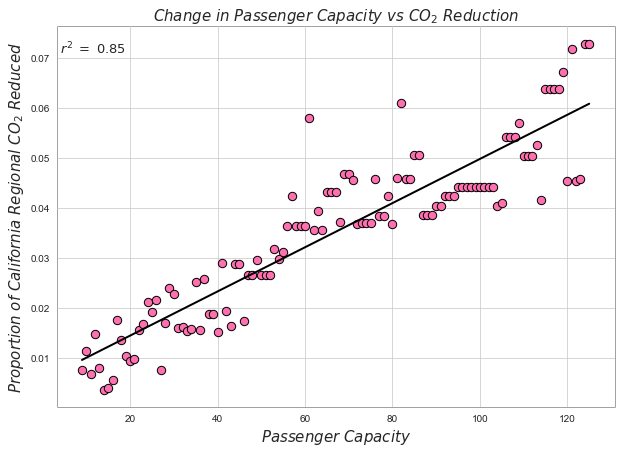

In [80]:
from sklearn.metrics import r2_score

# def cubic(x, a, b, c, d):
#     return a * x ** 3 + b * x ** 2 + c * x + d * x

# popt, pcov = curve_fit(cubic, np.array(range(9, 126)), np.array(total_reduction_pass_1))
# fit = cubic(np.array(range(9, 126)), *popt)
# r2 = r2_score(total_reduction_pass_1, fit)

fig, ax = plt.subplots(figsize = (10, 7))
plt.scatter(range(9, 126), total_reduction_pass_2, color = '#ff70b0', s = 70, edgecolor = 'black')
plt.plot(range(9, 126), yy, linewidth = 2, color = 'black');
plt.text(4, 0.071, '$r^{2}~=~0.85$', fontsize = 13)
plt.xlabel('$Passenger~Capacity$', fontsize = 15);
plt.ylabel('$Proportion~of~California~Regional~CO_{2}~Reduced$', fontsize = 15)
plt.title('$Change~in~Passenger~Capacity~vs~CO_{2}~Reduction$', fontsize = 15)
#ax.grid(False)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
plt.savefig('Article Figures/Final/pass_capacity_fig.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

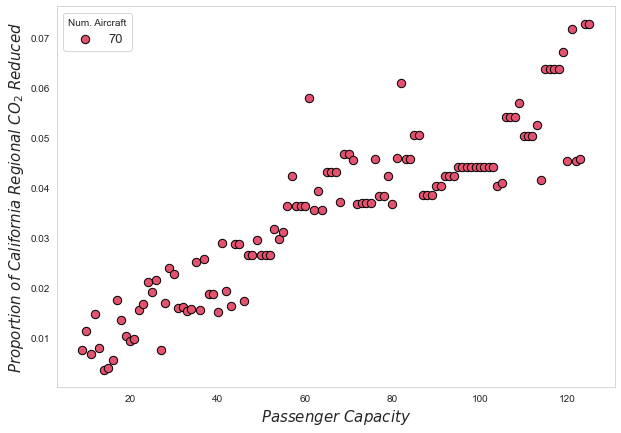

In [82]:
fig, ax = plt.subplots(figsize = (10, 7))
# plt.scatter(range(9, 126), total_reduction, color = '#88d61a', s = 70, edgecolor = 'black')
plt.scatter(range(9, 126), total_reduction_pass_2, color = '#e3526f', edgecolor = 'black', s = 70)
#plt.plot(range(9, 126), yy, '--', color = '#ff2b8e', linewidth = 3)
plt.xlabel('$Passenger~Capacity$', fontsize = 15)
plt.ylabel('$Proportion~of~California~Regional~CO_{2}~Reduced$', fontsize = 15)
plt.legend(['70', '35'], fontsize = 13, title = 'Num. Aircraft')
#plt.text(1, 0.0177, '$r^{2}~=~0.5$', fontsize = 13)
#plt.savefig('Article Figures/Final/pass_capacity_fig.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
ax.grid(False)
plt.show()

# 3. Network Visualization of Results

In [ ]:
# see iPython notebook 'Network Visualizations and Analysis'
subset.to_csv('eviation_alice_subset.csv', index = False)